<a href="https://colab.research.google.com/github/space-data-robert/cosmos-python-machine/blob/master/regressor_baseline_with_house_price_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

오늘은 주택 가격 예측 모델의 베이스라인을 잡을거에요.

주택 가격 데이터는 캐글에서 [다운로드](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) 하시면 되구요.

In [ ]:
data_name = 'house_price.csv'
target_name = 'SalePrice'

스크립트 실행 시에 경고를 제거할거에요.

경고를 읽는 것은 좋지만 출력이 어지럽답니다.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

이제 캐글 데이터를 불러오구요.

타겟 이름에 따라 데이터를 분할할거에요.
- 피처와 타겟 데이터

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)

data = pd.read_csv(data_name)

y_data = data[target_name]

print(f'data shape = {data.shape}')
data.head(2)

data shape = (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500


회귀 분석에서 타겟 분포는 매우 중요해요.

정규성을 만족하는지 확인 필요할 것 같네요.


In [ ]:
from scipy.stats import kstest

statistics, pvalue = kstest(
    y_data, 'norm',
    args=(y_data.mean(), y_data.var() ** 0.5)
)
print(f'normal pvalue = {pvalue:.3f}')

normal pvalue = 0.000


매우 작은 값이 나왔는데요.

이는 정규 분포와 다르다는 것을 의미해요.

정규 분포를 따지는 두가지가 있는데 알고 계시나요?
- 왜도가 절대값 10 이하
- 첨도는 절대값 3 미만


먼저 첨도를 확인해보면 위로 뾰족한 형태로 망했네요.

In [ ]:
from scipy.stats import kurtosis

kurtosis_ = kurtosis(y_data, fisher=False)
print(f'kurtosis = {kurtosis_: .3f}')

kurtosis =  9.510


디행이도 왜도의 경우는 정규성 조건을 만족해요.

In [ ]:
from scipy.stats import skew

skewness = skew(y_data)
print(f'skewness = {skewness: .3f}')

skewness =  1.881


하지만 걱정하지 마세요.

데이터에 로그를 씌운다면 이를 해결할 수 있어요.

아래와 같이 정규 분포와 거의 유사한 모습을 볼 수 있어요.

In [ ]:
y_data = y_data.apply(
    lambda x: np.log1p(x)
)

kurtosis_ = kurtosis(y_data, fisher=False)
skewness = skew(y_data)

print(f'kurtosis = {kurtosis_: .3f} skewness = {skewness: .3f}')

kurtosis =  3.803 skewness =  0.121


다음으로 중요한 피처가 어떠한 것들이 있는지 쓱 파악할거에요.

그 방법으로 피처 선택 모델을 활용합니다.
- 선택할 피처 개수는 50개

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_count = 50

selector = SelectKBest(f_regression, k=feature_count)

우리는 두가지 형태 피처를 가지고 있어요.
- 연속적인 또는 이산적인 값

따라서 원 핫 인코딩이 필요할거에요.

In [ ]:
x_data = pd.get_dummies(
    data, dummy_na=True
).dropna(axis=0)

y_data = x_data.pop(target_name)

print(f'x data shape = {x_data.shape}')
x_data.head(2)

x data shape = (1121, 332)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,1,60,65.0,8450,7,...,0,0,1,0,0
1,2,20,80.0,9600,6,...,0,0,1,0,0


이제 피팅을 시켜서 중요 피처를 확인해봅니다.

50개 피처가 뽑혔고 이산 데이터의 경우

언더바로 중요값까지 뽑힌걸 확인할 수 있을거에요.

In [ ]:
%time selector.fit_transform(x_data, y_data)

selected_mask = selector.get_support()
all_feature = x_data.columns

selected_feature = all_feature[selected_mask]

CPU times: user 16.8 ms, sys: 8.99 ms, total: 25.7 ms
Wall time: 18.7 ms


이 작업을 통해 우리는 피처 엔지니어링에서

선택과 집중을 할 수 있을 것이라 믿어요.
- 중요 피처 기준 탐색적 분석을 실시
- 중요 피처 결측치 체크


마지막으로 중복되는 피처 이름을 제거하고

리스트에 담아놓습니다.

In [ ]:
feature = pd.DataFrame(
    [f.split('_') for f in selected_feature],
    columns=['FeatureName', 'FeatureValue']
)
selected_feature = list(set(feature.FeatureName))

feature.T

,0,1,2,3,4,...,45,46,47,48,49
FeatureName,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,...,GarageType,GarageFinish,GarageFinish,SaleType,SaleCondition
FeatureValue,None,None,None,None,None,...,Detchd,Fin,Unf,New,Partial


이제 결측치를 처리해볼게요.

그렇다면 결측치가 얼마나 존재하는지 확인해야겠죠?
- 푸른색은 불완전한 데이터

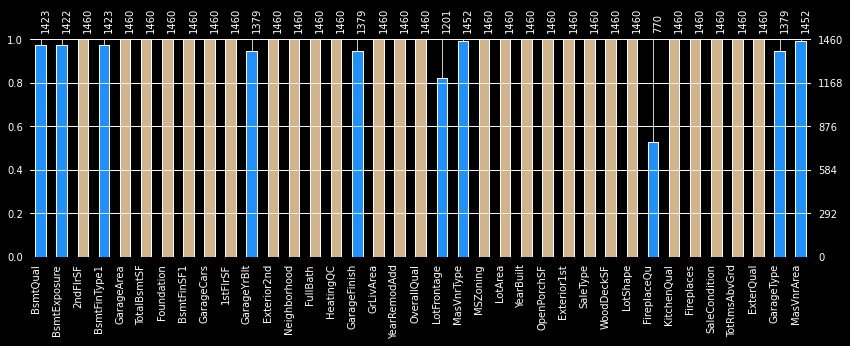

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('dark_background')

missing_mask = (
    data[selected_feature].isna().sum() != 0
).values

missing_map = {
    True: 'dodgerblue', 
    False: 'tan'
}
missing_mask = [missing_map[m] for m in missing_mask]

msno.bar(
    data[selected_feature],
    figsize=(14, 4), fontsize=10, label_rotation=90,
    color=missing_mask
)
plt.show()

이제 본격적으로 결측치 처리를 할건데요.

결측치 처리에는 크게 세가지가 존재해요.

이 장에서는 결측치 예측을 진행할 것이고

먼저 연속형 피처를 처리하도록 하죠.

In [ ]:
nummeric_feature = list()
categoric_feature = list()

for (f, m) in zip(selected_feature, missing_mask):
    if m != 'dodgerblue':
        continue
        
    if f in data.dtypes[data.dtypes != 'object'].index:
        nummeric_feature.append(f)
    else:
        categoric_feature.append(f)

missing_feature = nummeric_feature + categoric_feature

print(f'nummeric count = {len(nummeric_feature)}')

nummeric count = 3


그나저나 피처가 정말 잘 뽑힌게 맞나요?

상관 관계로 이를 짐작해 볼 수 있지 않을까요? (자문자답)

네. 확인해봅시다.

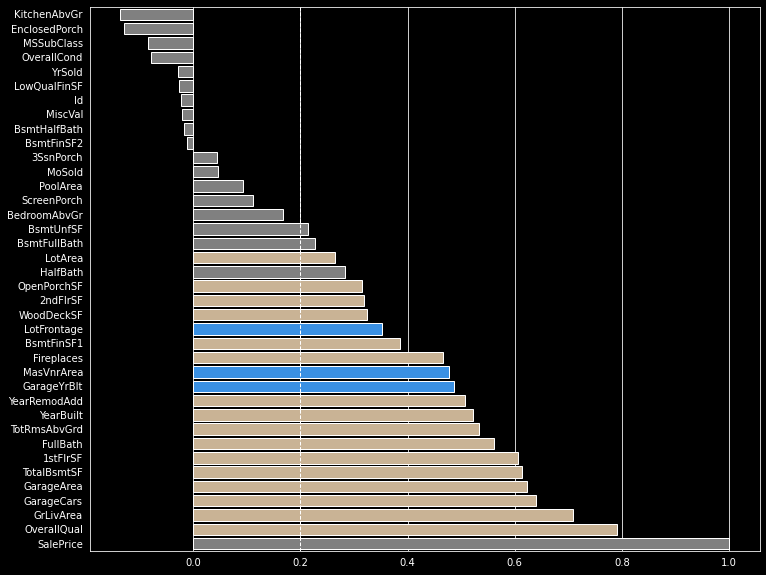

In [ ]:
import numpy as np
import seaborn as sns

plt.subplots(figsize=(12, 10))

correlated_feature = data.corr().SalePrice.sort_values()

missing_mask_ = [1 if f in missing_feature else 2 for f in correlated_feature.index]
selected_mask_ = [3 if f in selected_feature else 1 for f in correlated_feature.index]

correlated_mask = np.multiply(
    missing_mask_,
    selected_mask_
)

correlated_map = {
    1: 'gray',
    2: 'gray',
    3: 'dodgerblue',
    6: 'tan'
}
correlated_mask = [correlated_map[f] for f in correlated_mask]

sns.barplot(
    x=correlated_feature.values,
    y=correlated_feature.index,
    orient='h',
    palette=correlated_mask
)
plt.axvline(x=0.2, linewidth=1, linestyle='--')
plt.show()

네. 결과를 보아하니 중요한 피처가 맞습니다.

그럼 세가지 연속형 피처 결측을 예측해야겠죠?

여러가지 방법이 있을텐데요.

오늘은 상관 관계가 높은 피처로 이를 예측해 보려해요.

잠깐만요. 그거 아시나요?

결측치를 대체하거나 예측하려 할 때

너무 많은 양의 빈값이 있다면

우리는 해당 피처를 사용할 수 없어요.

따라서 빈값이 30% 이상인 경우 확인할거에요.
- 30% 이상인 경우 피처 활용을 고민

In [ ]:
imputed_feature = (
    data[nummeric_feature].isna().sum()
).to_frame('Isna')

imputed_feature.T

,GarageYrBlt,LotFrontage,MasVnrArea
Isna,81,259,8


이제 상관 관계를 시각화 해볼게요.

만약 상관 관계가 존재한다면 해당 변수로

우리 결측치를 채울 수 있어요.

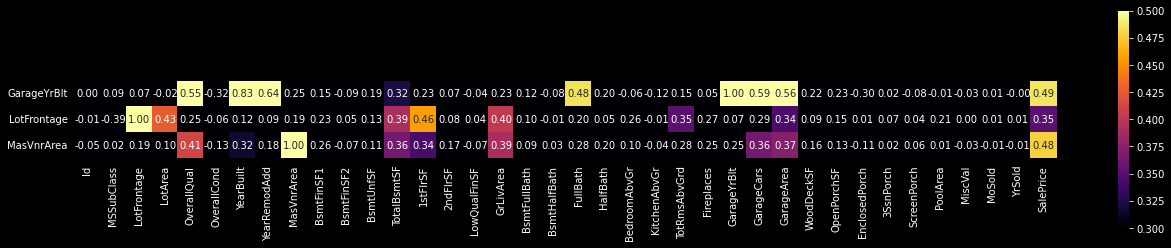

In [ ]:
plt.subplots(figsize=(22, 4))

sns.heatmap(
    data.corr().filter(
        imputed_feature.index).T,
    cbar=True, annot=True, square=True, fmt='.2f',
    cmap='inferno', vmin=0.3, vmax=0.5
)
plt.show()

자 이제 관계가 높은 데이터를 바탕으로

예측을 진행해주면 되는데요.

오토 임퓨트 모델을 사용해보도록 할게요.

In [ ]:
from autoimpute.imputations import SingleImputer

seed = 27

imputer = SingleImputer(
    strategy={
        'LotFrontage': 'pmm',
        'MasVnrArea': 'pmm', 
        'GarageYrBlt': 'pmm'
    },
    predictors={
        'LotFrontage': ['1stFlrSF', 'GrLivArea', 'LotArea'], 
        'MasVnrArea': ['OverallQual', 'GrLivArea', 'GarageArea'],
        'GarageYrBlt': ['YearBuilt', 'YearRemodAdd'],
        
        
    },
    seed=seed
)
imputer.fit(data)

%time data = imputer.transform(data)

In [ ]:
# data.to_csv('house_price_prepared_1.csv', header=True, index=False)

아래와 같이 세가지 연속형 피처의 빈값이

예측된 것을 확인할 수 있습니다.
- LotFrontage
- MasVnrArea
- GarageYrBlt

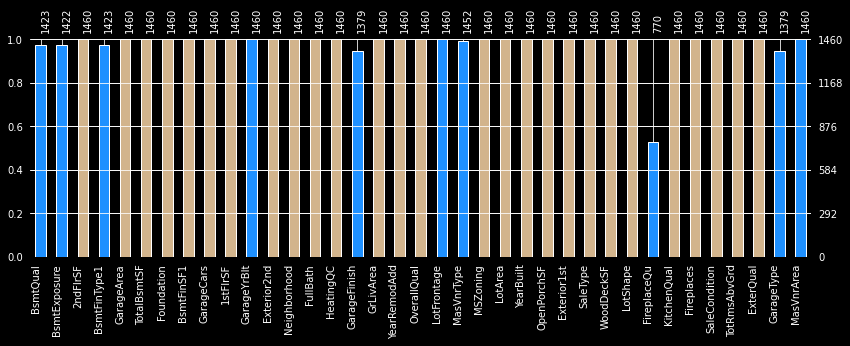

In [ ]:
msno.bar(
    data[selected_feature],
    figsize=(14, 4), fontsize=10, label_rotation=90,
    color=missing_mask
)
plt.show()

다시 이산형 결측 개수를 확인할 것이구요.

In [ ]:
imputed_feature = (
    data[categoric_feature].isna().sum()
).to_frame('Isna')

imputed_feature.T

,BsmtQual,BsmtExposure,BsmtFinType1,GarageFinish,MasVnrType,FireplaceQu,GarageType
Isna,37,38,37,81,8,690,81


이제 이산형 변수를 예측할 건데요.

이번에는 모든 변수를 활용해서 예측을 해보겠습니다.

- FireplaceQu 변수는 피처 엔지니어링에서 제외 고려

In [ ]:
imputer = SingleImputer(
    strategy={f: 'categorical' for f in categoric_feature},
    predictors={f: 'all' for f in categoric_feature},
    seed=seed,
)
imputer.fit(data)
data = imputer.transform(data)

모든 결측치를 채웠으므로

베이스라인 모델 성능 평가를 실시합니다.

다음으로 중요한 피처를 찾기 위한 목적으로

훈련과 테스트 데이터로 분할합니다.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, random_state=random_state
)
print(f'train shape = {x_train.shape}, {y_train.shape}')

data shape = (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500


훈련과 테스트 타겟 분포 일치 여부를 확인해요.

먼저 훈련과 테스트로 데이터를 분리하구요.



In [ ]:
import scipy.stats as stats

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, random_state=random_state
)

pvalue = stats.ks_2samp(
    y_train, y_test
).pvalue

print(f'pvalue = {pvalue:.3f}')

pvalue = 0.255


베이스라인과 같은 방식으로 중요도 기반 피처를 선택합니다.

중요도가 높은 피처 중에서 결측 빈도를 체크합니다.
- 파랑색은 중요한 피처를 의미하고 회색은 그렇지 않은 경우

결측값은 모델링에 방해 요소입니다.

따라서 결측치를 제거하거나 대체 또는 예측할 수 있습니다.

이번 스크립트에서 결측치 예측을 진행할 예정이며

먼저 연속형 변수에 대해 다루고 이후 카테고리 변수를 예측합니다.

연속형 변수 중에서 파랑색은 예측이 필요한 변수입니다.
- 노랑색은 결측치가 없으며 중요한 변수

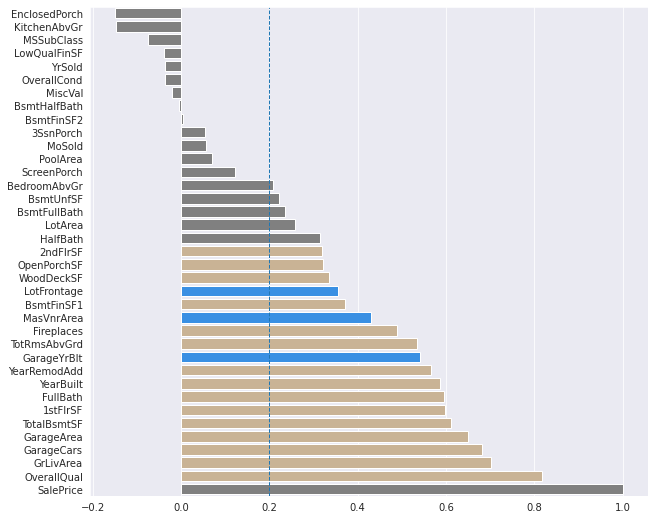

In [ ]:
import numpy as np

plt.subplots(figsize=(10, 9))

correlated_feature = data.corr().SalePrice.sort_values()

correlated_missing_mask = [1 if f in missing_feature else 2 for f in correlated_feature.index]
correlated_importance_mask = [3 if f in importance_feature else 1 for f in correlated_feature.index]

correlated_mask = np.multiply(
    correlated_missing_mask,
    correlated_importance_mask
)

correlated_map = {
    1: 'gray',          # this low importance.
    2: 'gray',          #      missing value.
    3: 'dodgerblue',    #      high importance and missing value.
    6: 'tan'            #      high importance and nice.
}
correlated_mask = [correlated_map[f] for f in correlated_mask]

sns.barplot(
    x=correlated_feature.values,
    y=correlated_feature.index,
    orient='h',
    palette=correlated_mask
)
plt.axvline(x=0.2, linewidth=1, linestyle='--')
plt.show()

또한 연속형 변수의 분포를 체크합니다.

회귀 분석 성능을 높이기 위해 독립 또한 정규 분포에 근사시킬 수 있습니다.

정규 분포 근사에는 여러가지 방법이 존재하나 이번 장에서는 박스콬스 변환을 실시합니다.

In [ ]:
from scipy.stats import skew

nummeric_feature = data.dtypes[data.dtypes != 'object'].index

def skewness_info(feature):
    skewed_feature = data[feature].apply(
        lambda x: skew(x.dropna())
    ).sort_values(ascending=False)

    skewness = skewed_feature.to_frame('Skew')
    return skewness

skewness = skewness_info(nummeric_feature)

print(f'skewness = {skewness.shape}')
skewness.T

skewness = (37, 1)


,MiscVal,PoolArea,LotArea,3SsnPorch,LowQualFinSF,...,FullBath,GarageCars,YearRemodAdd,YearBuilt,GarageYrBlt
Skew,24.45164,14.813135,12.195142,10.293752,9.00208,...,0.036524,-0.342197,-0.503044,-0.612831,-0.648708


정규 분포 판별에는 왜도와 첨도가 존재합니다.

이에 우리는 왜도를 변경합니다.

왜도(Skew)는 데이터가 한쪽으로 치우친 정도를 나타냅나다.

박스콕스 변환에는 람다 변수가 필요합니다.
- 람다는 로그, 제곱근 등의 멱함수 파라미터

따라서 박스콕스 함수로 람다를 먼저 찾습니다.

In [ ]:
from scipy.stats import boxcox

# this function is make a pipeline 1.1.

skewness = skewness[abs(skewness.Skew) >= 0.75]
skewed_feature = skewness.index
print(f'skwness count = {len(skewed_feature)}')

skewed_lambda = {
    f: [boxcox(
        data[data[f] > 0][f])[1]
    ] for f in skewed_feature
}
pd.DataFrame(skewed_lambda)

skwness count = 21


,MiscVal,PoolArea,LotArea,3SsnPorch,LowQualFinSF,...,MSSubClass,1stFlrSF,GrLivArea,BsmtUnfSF,2ndFlrSF
0,-0.200839,-2.890429,0.030946,0.51317,0.956013,...,-0.210841,-0.078832,0.006305,0.342103,0.525671


이제 실질적인 박스콕스 변환을 실시합니다.

변환된 데이터의 분포를 다시 확인하면 왜도가 줄어들었음을 확인할 수 있습니다.

In [ ]:
from scipy.special import boxcox1p

# this function is make a pipeline 1.2.  * lam = 0.15

for n, f in enumerate(skewed_feature):
    data[f] = boxcox1p(data[f], skewed_lambda[f])
    
print(f'boxcox transformed count = {n}')

skewness = skewness_info(nummeric_feature)
skewness.T

boxcox transformed count = 20


,PoolArea,LowQualFinSF,3SsnPorch,MiscVal,BsmtHalfBath,...,YearBuilt,GarageYrBlt,BsmtUnfSF,TotalBsmtSF,KitchenAbvGr
Skew,14.33793,8.929936,8.386848,5.041714,3.855436,...,-0.612831,-0.648708,-0.732488,-4.079598,-38.170678


위에서 중요한 피처 중에서 결측이 존재하는 세가지가 있었습니다.

즉 해당 변수의 결측을 처리하기 위해서는 관련이 높은 변수를 택할 필요가 있습니다.

우리는 어떤 변수가 상관 관계가 있는지 확인합니다.

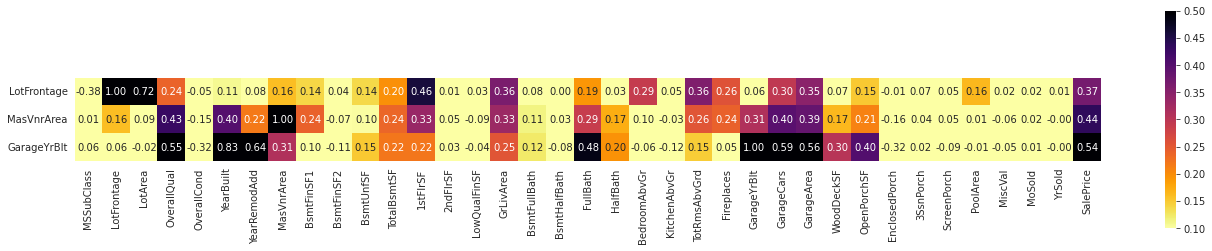

In [ ]:
plt.subplots(figsize=(23, 4))

threshold = len(data) * 0.7

imputed_feature = (
    data[missing_feature].isna().sum()
).to_frame('Isna')

imputed_feature = (
    imputed_feature[imputed_feature.Isna <= threshold]
).index

correlation = data.corr()

sns.heatmap(
    correlation.filter(imputed_feature).T,
    cbar=True, annot=True, square=True, fmt='.2f',
    cmap='inferno_r', vmin=0.1, vmax=0.5
)
plt.show()

관계가 있는 변수를 바탕으로 결측치 예측을 진행합니다.

해당 라이브러리를 사용하면 예측이 필요한 변수마다 

서로 다른 독립 변수를 활용할 수 있습니다.


In [ ]:
!pip install autoimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.5 MB/s 


In [ ]:
from autoimpute.imputations import SingleImputer

prep_data = data.copy()

# this function is make a pipeline.

imputer = SingleImputer(
    strategy={
        'LotFrontage': 'pmm',
        'MasVnrArea': 'pmm', 
        'GarageYrBlt': 'pmm'
    },
    predictors={
        'LotFrontage': ['1stFlrSF', 'GrLivArea', 'LotArea'], 
        'MasVnrArea': ['OverallQual', 'GrLivArea', 'GarageArea'],
        'GarageYrBlt': ['YearBuilt', 'YearRemodAdd'],
        
    },
    seed=27
)
imputer.fit(data)

%time pred_data = imputer.transform(data)

CPU times: user 6min 26s, sys: 4.06 s, total: 6min 30s
Wall time: 6min 31s


In [ ]:
_prep_data = prep_data.copy()

In [ ]:
_selected_feature = selected_feature.copy()

이제 연속형 피처가 잘 채워진 것을 확인할 수 있습니다.

In [ ]:
all_feature

{'1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtQual',
 'CentralAir',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageFinish',
 'GarageType',
 'GarageYrBlt',
 'GrLivArea',
 'HeatingQC',
 'KitchenQual',
 'LotFrontage',
 'LotShape',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'Neighborhood',
 'OpenPorchSF',
 'OverallQual',
 'SaleCondition',
 'SaleType',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd'}

In [ ]:
# selected_feature = _selected_feature.copy()

all_feature = set([f.split('_')[0] for f in _selected_feature])

_prep_data = _prep_data[all_feature]

missing_mask = (
    _prep_data.isna().sum() != 0
).values

missing_mask = ['dodgerblue' if m == True else 'tan' for m in missing_mask]

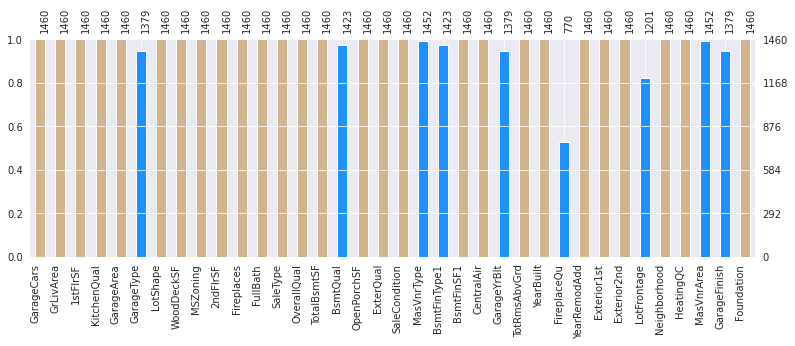

In [ ]:
msno.bar(
    _prep_data,
    figsize=(13, 4), fontsize=10, label_rotation=90,
    color=missing_mask
)
plt.show()

In [ ]:
_nummeric_feature = [f for f in all_feature if f in nummeric_feature]
_nummeric_feature

NameError: ignored

In [ ]:
missing_feature = [f for f, m in zip(all_feature, missing_mask) if m == 'dodgerblue'] 

x = missing_feature[0]

['GarageType',
 'BsmtQual',
 'MasVnrType',
 'BsmtFinType1',
 'GarageYrBlt',
 'FireplaceQu',
 'LotFrontage',
 'MasVnrArea',
 'GarageFinish']

In [ ]:
nume

In [ ]:
x = missing_feature[0]

plt.figure(figsize=(12 ,5))
sns.countplot(data=_prep_data, x=, hue=x)

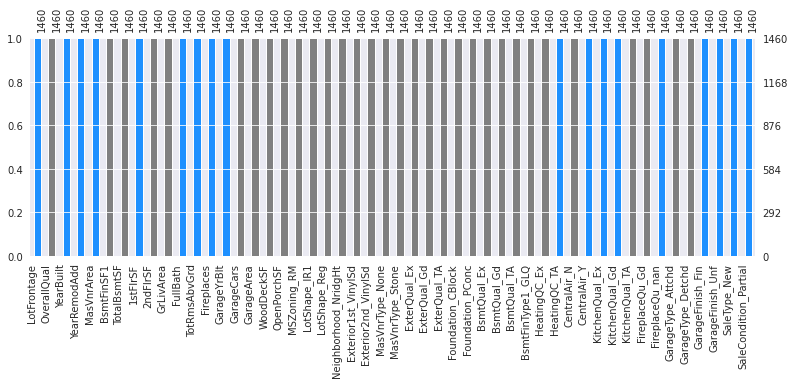

In [ ]:
# nummerical_selected_feature = selected_feature & nummerical_feature

# msno.bar(
#     pd.get_dummies(
#         prep_data, dummy_na=True
#     ).filter(selected_feature),
#     figsize=(13, 4), fontsize=10, label_rotation=90,
#     color=importance_mask
# )
# plt.show()

이제 카테고리 변수 예측이 필요합니다.

위 결측 그래프에서 카테고리 변수 결측이 존재하지 않는 이유는

원핫 인코딩을 진행했기 때문입니다.

따라서 빈값이 어떤 의미를 가지고 있는지 확인할 필요가 있습니다.
- 새로운 데이터에서 빈값 존재 시 처리가 필요하기 때문

In [ ]:
# num_selected_feature = selected_feature & num_feature

# clean_data = pd.concat([
#     prep_data.filter(
#         list(num_selected_feature) + list(cat_feature)),
#     pred_data],
#     axis=1
# )
# # clean_data.to_csv('house_price_clean_num.csv', index=False, header=True)

# print(f'clean data shape = {clean_data.shape}')
# clean_data.head(2)

In [ ]:
y_data = data.SalePrice

data = pd.read_csv('house_price_clean_num.csv')

data = pd.concat([data, y_data], axis=1)

print(data.shape)
data.head(2)

(1460, 64)


,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType,SaleCondition,IsTrain,PredSalePrice,SalePrice
0,4.232750,7,2003,2003,3.592544,...,WD,Normal,True,NaN,12.247699
1,4.485301,6,1976,1976,0.000000,...,WD,Normal,True,NaN,12.109016


In [ ]:
nummerical_selected_feature = selected_feature & nummerical_feature

In [ ]:
nummerical_selected_feature

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

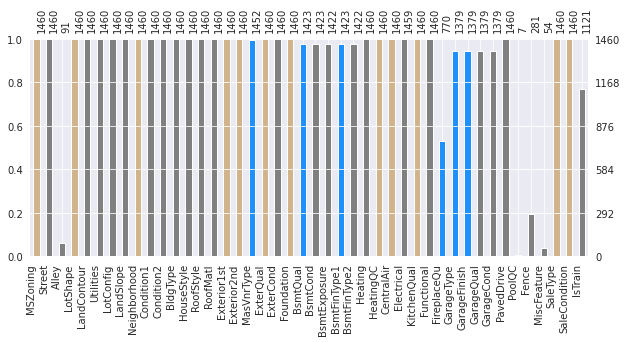

In [ ]:
categorical_feature = data.dtypes[data.dtypes == 'object'].index

importance_feature = feature.ImportantFeature.values

correlated_missing_mask = [1 if f in missing_feature else 2 for f in categorical_feature]
correlated_importance_mask = [3 if f in importance_feature else 1 for f in categorical_feature]

correlated_mask = np.multiply(
    correlated_missing_mask,
    correlated_importance_mask
)
correlated_mask = [correlated_map[f] for f in correlated_mask]

msno.bar(
    data[categorical_feature],
    figsize=(10, 4), fontsize=10, label_rotation=90,
    color=correlated_mask
)
plt.show()

In [ ]:
missing_feature = [f for f, m in zip(categorical_feature, correlated_mask) if m == 'dodgerblue']

missing_feature

['MasVnrType',
 'BsmtQual',
 'BsmtFinType1',
 'FireplaceQu',
 'GarageType',
 'GarageFinish']

In [ ]:
# 'MasVnrType',
#  'BsmtQual',
#  'BsmtFinType1',
#  'FireplaceQu',
#  'GarageType',
#  'GarageFinish'

(1460, 63)


,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,MiscFeature,SaleType,SaleCondition,IsTrain,PredSalePrice
0,4.232750,7,2003,2003,3.592544,...,NaN,WD,Normal,True,NaN
1,4.485301,6,1976,1976,0.000000,...,NaN,WD,Normal,True,NaN


In [ ]:
data.MasVnrType

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'IsTrain'],
      dtype='object')